### Dependencies

In [ ]:
HAS_CUDA_CUDNN  = input('CUDA and CuDNN installed? (y/n): ') == 'y'

DEPENDENCIES    = [
    'numpy',
    'scipy',
    'scikit-learn',
    'matplotlib',
    'keras',
    'tensorflow-gpu' if HAS_CUDA_CUDNN else 'tensorflow',
    'h5py'
]

import pip

for dependency in DEPENDENCIES:
    pip.main(['install', dependency])

# MNIST

### Loading

In [2]:
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()

### Visualization

In [4]:
import matplotlib.pyplot as pplt
import matplotlib.cm     as cmap

% matplotlib inline

In [5]:
from random import randint

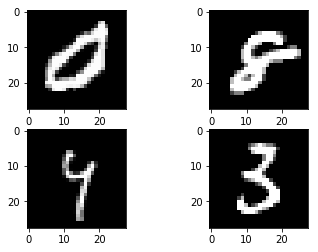

In [6]:
nsamples = len(Xtrain)
nplots   = 4

for i in range(nplots):
    pplt.subplot(220 + (i + 1))
    
    index  = randint(0, nsamples)
    sample = Xtrain[index]
        
    pplt.imshow(sample, cmap = cmap.gray)

### Preprocessing

In [7]:
import numpy as np

#### Flattening

In [8]:
def flatten(x, dtype = np.uint8):
    nsamples, width, height = x.shape
    ncols = width * height
    
    x     = x.reshape(nsamples, ncols).astype(dtype)
    
    return x

In [9]:
Xtrain, Xtest = flatten(Xtrain), flatten(Xtest)

#### Scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler        = MinMaxScaler()

In [12]:
Xtrain, Xtest = scaler.fit_transform(Xtrain), scaler.fit_transform(Xtest)

/home/achilles/digdet/.venv/py3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


#### Encoding

In [13]:
from keras.utils import np_utils

In [14]:
ytrain, ytest = np_utils.to_categorical(ytrain), np_utils.to_categorical(ytest)

### Modelling

In [15]:
from keras.models import Sequential
from keras.layers import Dense

In [16]:
ninp   = Xtrain.shape[1]
nout   = ytrain.shape[1]
config = { "loss": "categorical_crossentropy", "optimizer": "adam", "metrics": ["accuracy"] }

ninp, nout

(784, 10)

In [17]:
def get_model():
    ninp   = 784
    nout   = 10

    layers = [512, 512, 10]
    config = { "loss": "categorical_crossentropy", "optimizer": "adam", "metrics": ["accuracy"] }
    model  = Sequential()
    
    model.add(Dense(layers[0], input_shape = (ninp,), activation = 'relu', kernel_initializer = 'normal'))
    
    for i in range(1, len(layers) - 1):
        model.add(Dense(layers[i], activation = 'relu'))
        
    model.add(Dense(layers[-1], activation = 'softmax'))
    
    model.compile(**config)
    
    return model

In [18]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Training

In [19]:
batch_size = 128
nepochs    = 20

In [20]:
history = model.fit(Xtrain, ytrain,
                    batch_size      = batch_size,
                    epochs          = nepochs,
                    verbose         = 2,
                    validation_data = (Xtest, ytest))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
3s - loss: 0.2149 - acc: 0.9364 - val_loss: 0.1066 - val_acc: 0.9668
Epoch 2/20
3s - loss: 0.0799 - acc: 0.9755 - val_loss: 0.0814 - val_acc: 0.9734
Epoch 3/20
3s - loss: 0.0484 - acc: 0.9845 - val_loss: 0.0820 - val_acc: 0.9758
Epoch 4/20
3s - loss: 0.0333 - acc: 0.9890 - val_loss: 0.0706 - val_acc: 0.9789
Epoch 5/20
3s - loss: 0.0265 - acc: 0.9909 - val_loss: 0.0904 - val_acc: 0.9744
Epoch 6/20
3s - loss: 0.0218 - acc: 0.9927 - val_loss: 0.0975 - val_acc: 0.9709
Epoch 7/20
3s - loss: 0.0179 - acc: 0.9938 - val_loss: 0.0941 - val_acc: 0.9764
Epoch 8/20
3s - loss: 0.0177 - acc: 0.9939 - val_loss: 0.0835 - val_acc: 0.9789
Epoch 9/20
3s - loss: 0.0127 - acc: 0.9959 - val_loss: 0.0846 - val_acc: 0.9796
Epoch 10/20
3s - loss: 0.0118 - acc: 0.9958 - val_loss: 0.0856 - val_acc: 0.9801
Epoch 11/20
3s - loss: 0.0120 - acc: 0.9958 - val_loss: 0.0840 - val_acc: 0.9803
Epoch 12/20
3s - loss: 0.0102 - acc: 0.9967 - val_loss: 0.0791 - val

In [21]:
pplt.style.use('seaborn')

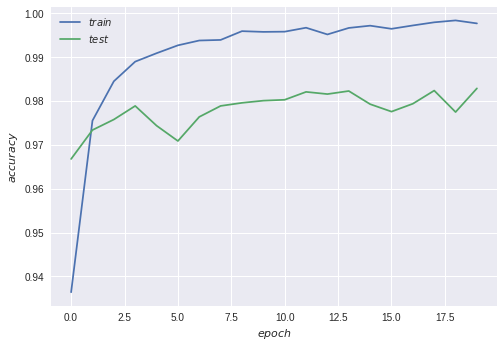

In [22]:
pplt.plot(history.history['acc'])
pplt.plot(history.history['val_acc'])

pplt.xlabel('$epoch$')
pplt.ylabel('$accuracy$')

pplt.legend(['$train$', '$test$'])

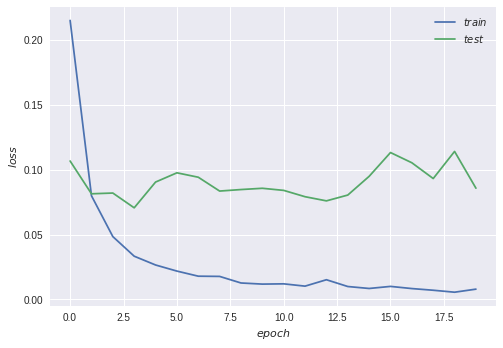

In [23]:
pplt.plot(history.history['loss'])
pplt.plot(history.history['val_loss'])

pplt.xlabel('$epoch$')
pplt.ylabel('$loss$')

pplt.legend(['$train$', '$test$'])

### Testing

In [24]:
score = model.evaluate(Xtest, ytest)

 9824/10000 [============================>.] - ETA: 0s

In [25]:
print('Accuracy: ', score[1] * 100)

Accuracy:  98.29


### Saving

In [26]:
import os, errno

RELPATH_DATA   = 'data'
RELPATH_MODELS = os.path.join(RELPATH_DATA, 'models')

def makedirs(path, ignore_exists = False):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno == errno.EEXIST:
            if not ignore_exists:
                raise e
        else:
            raise e
            
makedirs(RELPATH_MODELS, ignore_exists = True)

In [27]:
name = input('Directory: ')

Directory: mnist


In [28]:
RELPATH_DIR = os.path.join(RELPATH_MODELS, name)

makedirs(RELPATH_DIR, ignore_exists = True)

In [29]:
import json

In [30]:
json_ = model.to_json()

with open(os.path.join(RELPATH_DIR, 'model.json'), 'w') as f:
    f.write(json_)

In [31]:
model.save_weights(os.path.join(RELPATH_DIR, 'model.h5'))

In [32]:
with open(os.path.join(RELPATH_DIR, 'config.json'), 'w') as f:
    json.dump(config, f)